In [1]:
import sys
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import RobustScaler, StandardScaler, MinMaxScaler
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.model_selection import KFold
from sklearn.decomposition import PCA
from pykliep_rep.pykliep import DensityRatioEstimator 
from lofo import LOFOImportance, Dataset, plot_importance

import warnings
def ignore_warn(*args, **kwargs):
    pass
warnings.warn = ignore_warn 

from scipy import stats
from scipy.stats import norm, skew, boxcox
from scipy.special import boxcox1p, inv_boxcox

def metric(y_true, y_pred):
    return np.mean(np.sum(np.abs(y_true - y_pred), axis=0)/np.sum(y_true, axis=0))

/home/sunny/venv/lib/python3.6/site-packages/lofo/lofo_importance.py:4: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
fnc = pd.read_csv('fnc.csv')
loading = pd.read_csv('loading.csv')
reveal = pd.read_csv('reveal_ID_site2.csv')
sample = pd.read_csv('sample_submission.csv')
train_scores = pd.read_csv('train_scores.csv')

fnc_features, loading_features = list(fnc.columns[1:]), list(loading.columns[1:])

df = fnc.merge(loading, on="Id")

In [3]:
SEED = 0
NUM_FOLDS = 7
FNC_SCALE = 1/500

In [4]:
scaler = MinMaxScaler()
df.iloc[:,1:] = scaler.fit_transform(df.iloc[:,1:])
scaler = RobustScaler()
df.iloc[:,1:] = scaler.fit_transform(df.iloc[:,1:])

train_scores["is_train"] = True

df = df.merge(train_scores, on="Id", how="left")
test_df = df[df["is_train"] != True].copy()
df = df[df["is_train"] == True].copy()

df[fnc_features] *= FNC_SCALE
test_df[fnc_features] *= FNC_SCALE

In [5]:
#calculation of skewed features in fnc_features

skewness_fnc = {}
for col in fnc_features:
    skewness_fnc['{:,.2f}'.format(abs(skew(df[col])))] = col
    
for keys, values in sorted(skewness_fnc.items(), reverse=True)[:10]:
    print('{} : {}'.format(values, keys))

VSN(8)_vs_VSN(15) : 2.24
VSN(20)_vs_VSN(12) : 1.96
VSN(15)_vs_VSN(16) : 1.33
VSN(15)_vs_VSN(5) : 1.30
VSN(20)_vs_VSN(15) : 1.27
VSN(8)_vs_VSN(16) : 1.26
VSN(8)_vs_VSN(5) : 1.21
DMN(94)_vs_CON(96) : 1.19
DMN(94)_vs_CON(43) : 1.14
VSN(12)_vs_VSN(15) : 1.13


In [6]:
skewed_fnc_features = []

for i in sorted(skewness_fnc.keys(), reverse=True):
    
    if float(i)>=0.75:
        skewed_fnc_features.append(skewness_fnc[i])
        
for col in skewed_fnc_features:
    
    _, param = stats.yeojohnson(df[col])
    df[col] = stats.yeojohnson(df[col], param)

In [7]:
for col in skewed_fnc_features:
    print ( '{} : {:,.2f}'.format(col, skew(df[col])) )

VSN(8)_vs_VSN(15) : -0.22
VSN(20)_vs_VSN(12) : -0.19
VSN(15)_vs_VSN(16) : -0.11
VSN(15)_vs_VSN(5) : -0.13
VSN(20)_vs_VSN(15) : -0.09
VSN(8)_vs_VSN(16) : -0.11
VSN(8)_vs_VSN(5) : -0.11
DMN(94)_vs_CON(96) : -0.05
DMN(94)_vs_CON(43) : -0.04
VSN(12)_vs_VSN(15) : -0.10
VSN(8)_vs_VSN(20) : -0.09
VSN(8)_vs_VSN(12) : -0.09
VSN(12)_vs_VSN(5) : -0.09
DMN(94)_vs_CON(79) : 0.03
CON(79)_vs_CON(43) : 0.03
DMN(23)_vs_CON(43) : -0.03
DMN(94)_vs_DMN(40) : -0.04
SMN(3)_vs_ADN(56) : -0.04
DMN(94)_vs_DMN(23) : -0.03
DMN(17)_vs_DMN(23) : -0.02
VSN(16)_vs_SMN(9) : 0.03
CON(79)_vs_SMN(80) : -0.03
CON(96)_vs_CON(43) : -0.03
CON(79)_vs_SMN(72) : -0.02


In [8]:
#calculation of skewed features in loading_features

skewness_loading = {}
for col in loading_features:
    skewness_loading['{:,.2f}'.format(abs(skew(df[col])))] = col
    
for keys, values in sorted(skewness_loading.items(), reverse=True)[:5]:
    print('{} : {}'.format(values, keys))

IC_18 : 0.76
IC_26 : 0.36
IC_03 : 0.34
IC_29 : 0.33
IC_14 : 0.27


In [9]:
skewed_load_features = []

for i in sorted(skewness_loading.keys(), reverse=True):
    
    if float(i)>=0.75:
        skewed_load_features.append(skewness_loading[i])

for col in skewed_load_features:
    
    _, param = stats.yeojohnson(df[col])
    df[col] = stats.yeojohnson(df[col], param)

In [10]:
for col in skewed_load_features:
    print ( '{} : {}'.format(col, skew(df[col])) )

IC_18 : -0.0005362745578965887


In [11]:
fnc_initials = list(set([x.split('(')[0] for x in fnc_features]))
fnc_initials_dict = {}
for i in fnc_initials:
    count = 0
    for f in fnc_features:
        if f.startswith(i):
            count += 1
    fnc_initials_dict[i] = count

print(fnc_initials_dict)

{'ADN': 11, 'CON': 561, 'SMN': 99, 'DMN': 315, 'VSN': 180, 'CBN': 202, 'SCN': 10}


In [12]:
fnc_finals = np.zeros((df.shape[0],1))

for i in fnc_initials:
    
    pca = PCA(n_components = (fnc_initials_dict[i]//5 + 1))
    reqd_features = [x for x in fnc_features if x.startswith(i)]
    fnc_finals = np.concatenate((fnc_finals, pca.fit_transform(df[reqd_features])), axis=1)
    
fnc_finals = pd.DataFrame(fnc_finals[:,1:])

In [13]:
fnc_finals

,0,1,2,3,4,5,6,7,8,9,...,271,272,273,274,275,276,277,278,279,280
0,-0.000638,0.000804,-0.000392,-0.007729,-0.005433,0.004228,-0.007292,-0.002125,-0.004909,0.002243,...,-0.001512,-0.000769,0.001444,-0.000200,-0.000003,0.001899,-0.001591,-0.002608,-0.001974,1.988505e-07
1,0.001643,-0.000997,-0.001700,-0.006600,0.003468,0.015063,0.001441,0.000285,0.003981,0.002902,...,-0.000735,-0.001163,0.001258,0.003335,0.000352,0.001364,-0.003013,-0.004095,0.000624,-3.644176e-04
2,-0.003660,0.000032,0.002506,-0.003096,-0.003129,0.007581,0.001759,0.003902,-0.001997,-0.006715,...,0.000995,0.000632,-0.002013,0.000092,0.000833,0.000429,0.000223,-0.001903,0.000131,2.041744e-03
3,0.000111,-0.000659,-0.000941,0.000087,0.002691,-0.002845,0.007671,-0.005639,-0.004424,0.005842,...,0.002109,-0.002308,0.001053,0.000277,-0.000125,0.000888,0.000527,-0.000398,0.000626,-4.250759e-04
4,0.001613,0.001167,-0.002066,0.002007,-0.003108,0.002166,0.012524,-0.002470,0.011187,-0.004453,...,0.001607,-0.002311,0.000435,-0.000628,-0.000021,-0.000543,-0.000042,0.000616,0.000871,1.423941e-03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5872,-0.004843,-0.000003,-0.001064,-0.001062,-0.001879,-0.009581,-0.000778,-0.007970,-0.001269,-0.004500,...,-0.001557,0.000269,-0.001087,-0.001026,-0.000084,-0.000108,-0.000782,-0.002700,0.002563,-5.736358e-04
5873,-0.002640,0.000396,-0.001519,0.005155,0.014472,-0.018884,0.008062,-0.002373,0.002084,-0.000040,...,0.002377,-0.000311,0.000129,0.001115,-0.001159,-0.000570,0.000424,0.006678,0.003821,-1.473541e-03
5874,-0.001090,-0.002597,0.000376,-0.006135,-0.007656,-0.009037,-0.001078,0.011032,0.001285,-0.003440,...,0.002182,-0.001147,0.000473,0.000375,-0.000304,-0.000143,0.000231,-0.005457,-0.001447,-2.303724e-03
5875,0.002885,0.001671,0.000199,0.010901,-0.005668,-0.003513,0.002159,0.004907,0.007378,0.003835,...,0.000564,-0.001192,0.001211,0.001160,0.001043,-0.000561,0.002028,0.002314,0.000893,2.795366e-03


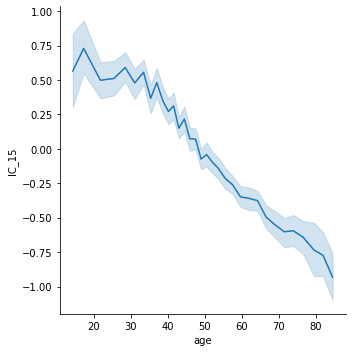

In [14]:
sns.relplot(x='age',y='IC_15', data=df,kind='line')

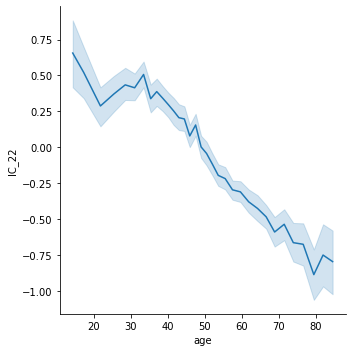

In [15]:
sns.relplot(x='age',y='IC_22', data=df, kind='line')

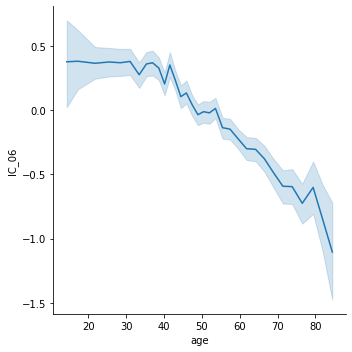

In [16]:
sns.relplot(x='age',y='IC_06', data=df, kind='line')

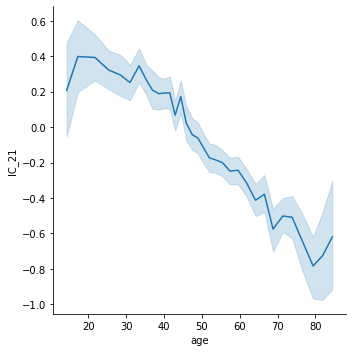

In [17]:
sns.relplot(x='age',y='IC_21', data=df, kind='line')

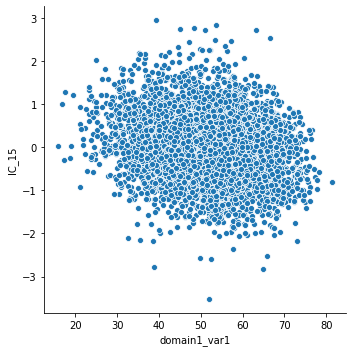

In [18]:
sns.relplot(x='domain1_var1',y='IC_15', data=df )

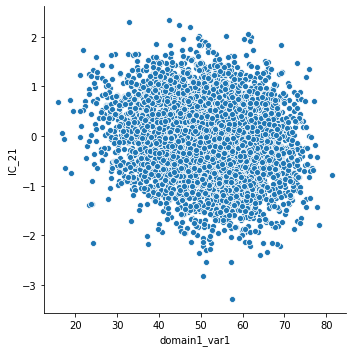

In [19]:
sns.relplot(x='domain1_var1',y='IC_21', data=df)

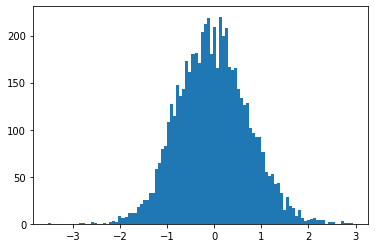

In [20]:
plt.hist(df.IC_15, bins=100)
plt.show()

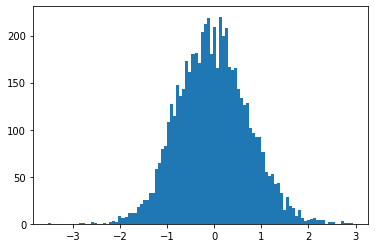

In [21]:
plt.hist(df.IC_15, bins=100)
plt.show()

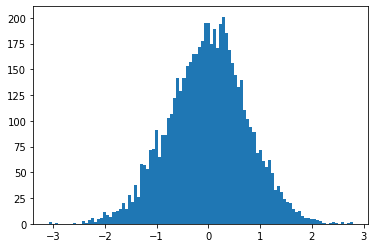

In [22]:
plt.hist(df.IC_06, bins=100)
plt.show()

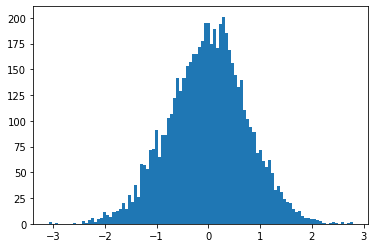

In [23]:
plt.hist(df.IC_06, bins=100)
plt.show()

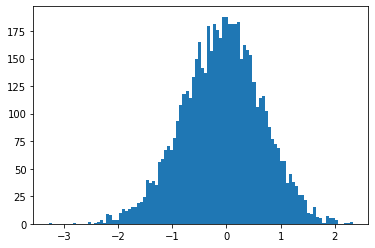

In [24]:
plt.hist(df.IC_21, bins=100)
plt.show()

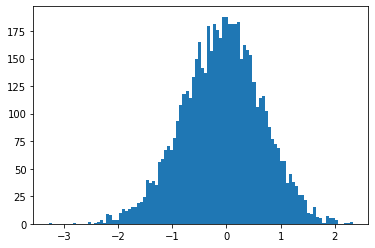

In [25]:
plt.hist(df.IC_21, bins=100)
plt.show()

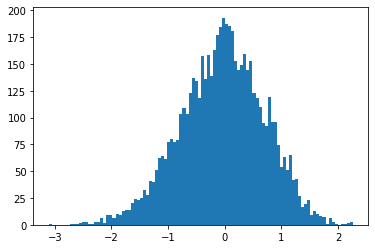

In [26]:
plt.hist(df.IC_22, bins=100)
plt.show()

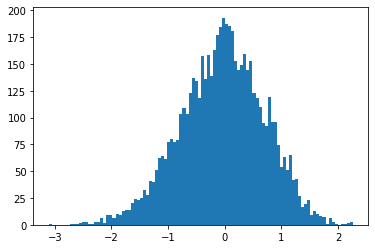

In [27]:
plt.hist(df.IC_22, bins=100)
plt.show()

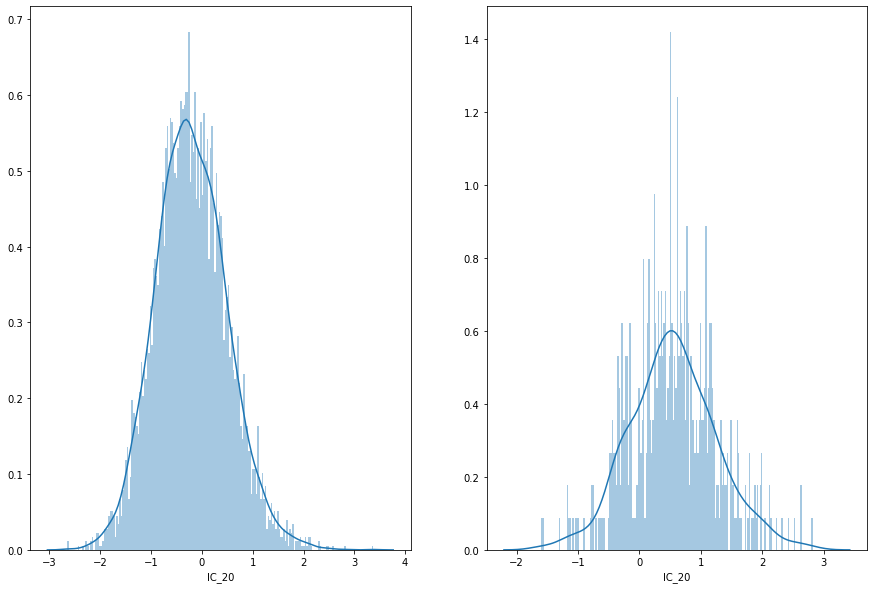

In [28]:
fig, ax = plt.subplots(1,2, figsize=(15,10))
sns.distplot(df.IC_20, bins=200, ax=ax[0])
sns.distplot(test_df[test_df.Id.isin(reveal.Id.values)].IC_20, bins=200, ax=ax[1])
plt.show()

In [29]:
for col in loading.columns[1:]:
    train_val = df[col].mean() 
    test_val = test_df[test_df.Id.isin(reveal.Id.values)][col].mean()
    diff = (test_val - train_val)/train_val * 100
    print(col, '{:.2f}'.format(diff))

IC_01 -76.60
IC_07 283.22
IC_05 -550.38
IC_16 -1582.22
IC_26 -156.08
IC_06 694.15
IC_10 1408.12
IC_09 -292.23
IC_18 -542.21
IC_04 256.65
IC_12 -51.54
IC_24 80.67
IC_15 -815.68
IC_13 3410.21
IC_17 199.76
IC_02 -1605.56
IC_08 -1233.58
IC_03 159.71
IC_21 -179.03
IC_28 -340.48
IC_11 45.12
IC_20 -368.73
IC_30 -137.59
IC_22 -132.28
IC_29 978.01
IC_14 423.12


In [30]:
fnc_features, loading_features = list(fnc.columns[1:]), list(loading.columns[1:])

In [31]:
def get_lofo_importance(target, alpha):
    cv = KFold(n_splits=5, shuffle=True, random_state=0)

    dataset = Dataset(df=df[df[target].notnull()], target=target, features=loading_features, 
                      feature_groups={"fnc": df[df[target].notnull()][fnc_features].values/500})
    
    model = Ridge(alpha = alpha)
    lofo_imp = LOFOImportance(dataset, cv=cv, scoring="neg_mean_absolute_error", model=model)

    return lofo_imp.get_importance()

In [32]:
age_imp = get_lofo_importance(target="age", alpha=0.0002)
d1v1_imp = get_lofo_importance(target="domain1_var1", alpha=0.005)
d1v2_imp = get_lofo_importance(target="domain1_var2", alpha=0.025)
d2v1_imp = get_lofo_importance(target="domain2_var1", alpha=0.007)
d2v2_imp = get_lofo_importance(target="domain2_var2", alpha=0.002)

In [33]:
#plotting the importance of features wrt each target

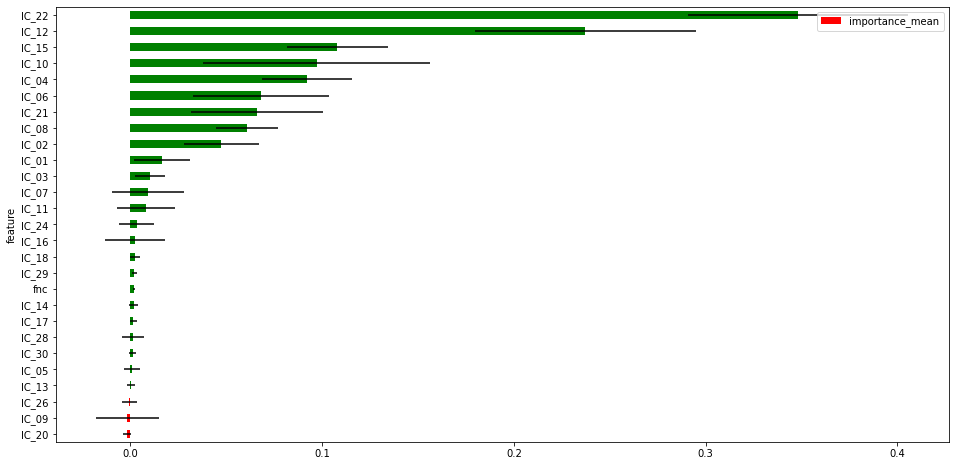

In [34]:
plot_importance(age_imp, figsize=(16, 8))

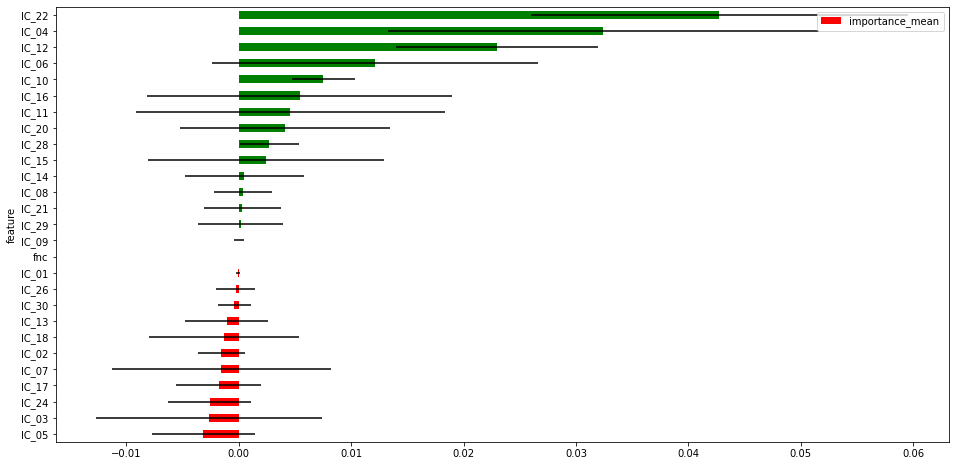

In [35]:
plot_importance(d1v1_imp, figsize=(16, 8))

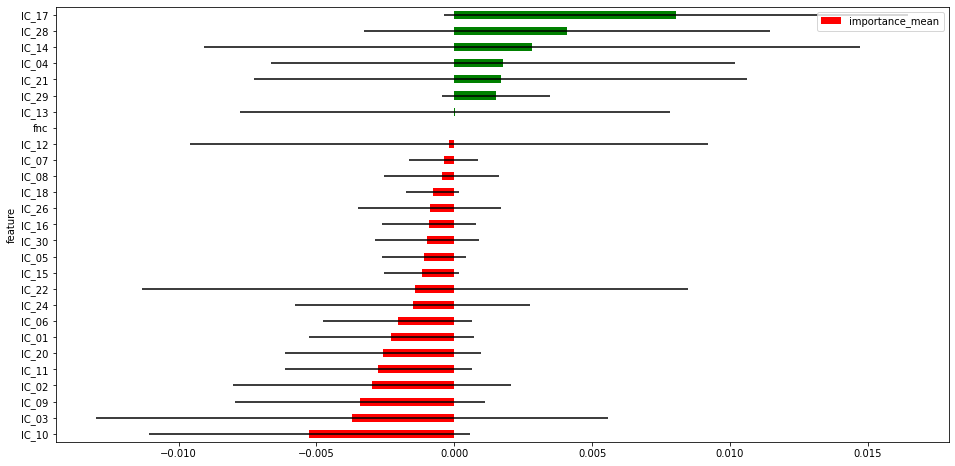

In [36]:
plot_importance(d1v2_imp, figsize=(16, 8))

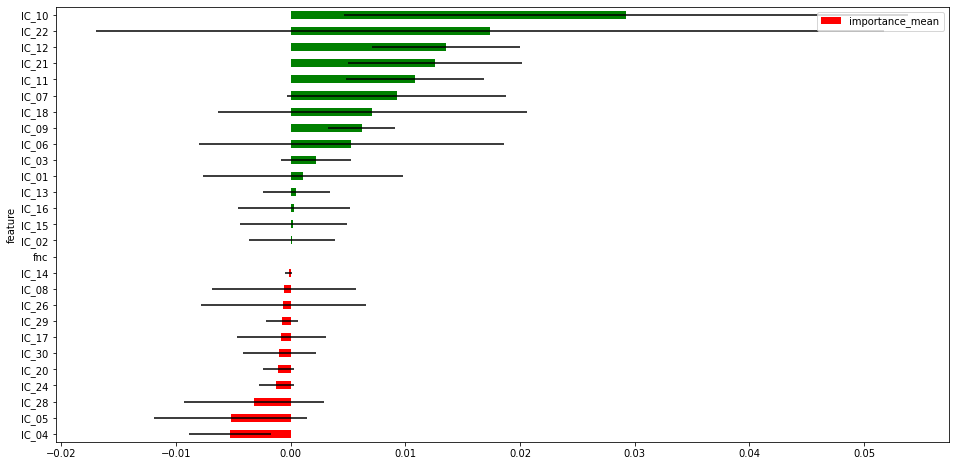

In [37]:
plot_importance(d2v1_imp, figsize=(16, 8))

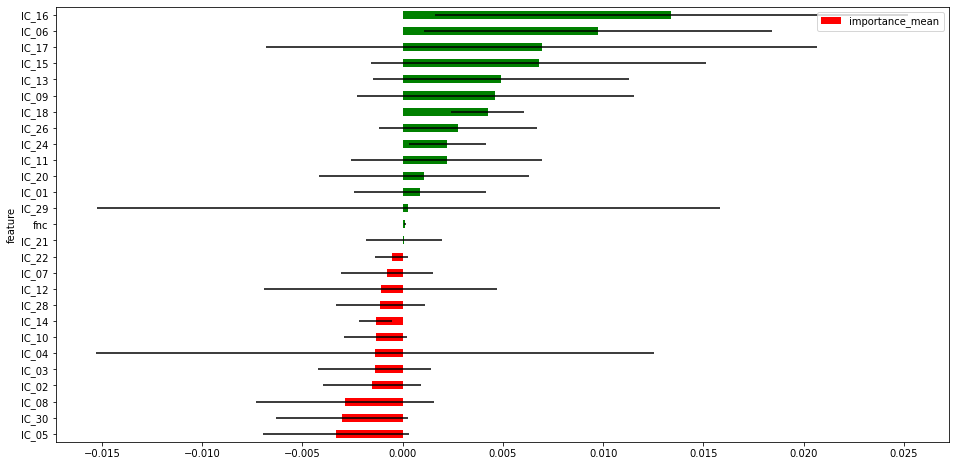

In [38]:
plot_importance(d2v2_imp, figsize=(16, 8))